Link do Prof: http://professor.ufabc.edu.br/~jesus.mena/imunoBR

In [1]:
# !wget -O imunoBR-rede-total.gexf "http://professor.ufabc.edu.br/~jesus.mena/imunoBR/old2/imunoBR-rede-total.gexf"

# !wget -q http://professor.ufabc.edu.br/~jesus.mena/imunoBR/imunoBR-tabelas-csv.tgz -O imunoBR.tgz

# !tar -xvzf imunoBR.tgz


In [2]:
# %pip install tqdm

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import random
from math import sqrt

import time
import requests
from difflib import SequenceMatcher
import pandas as pd
import numpy as np
# import rapidfuzz

import os
import tarfile

from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import defaultdict

from tqdm import tqdm
import json

%matplotlib inline

In [4]:
import re

# Load in NetworkX
grafo = nx.read_gexf("src/imunoBR-rede-total_clean.gexf")

In [5]:
df_extra_infos = pd.read_csv("src/imunoBR-tabelas-csv/imunoBR---Tabela-consolidada.csv", sep='\t', encoding='utf-8')

df_extra_infos['ID-Lattes'] = (
    df_extra_infos['ID-Lattes']
    .astype(str)
    .str.strip()                      # remove espaços antes/depois
    .str.replace(r"^'+", "", regex=True)  # remove um ou mais apóstrofos no começo
)

In [6]:
num_nos = grafo.number_of_nodes()
num_arestas = grafo.number_of_edges()
densidade = nx.density(grafo)
grau_medio = sum(dict(grafo.degree()).values()) / num_nos

# Componentes conexos

componentes_conexos = nx.number_connected_components(grafo)
maior_componente = len(max(nx.connected_components(grafo), key=len))

resultados = {}
# Armazenar resultados
resultados['composicao'] = {
    'num_nos': num_nos,
    'num_arestas': num_arestas,
    'densidade': densidade,
    'grau_medio': grau_medio
}

# Imprimir resultados
print(f"Número de nós (pesquisadores): {num_nos:,}")
print(f"Número de arestas (colaborações): {num_arestas:,}")
print(f"Densidade da rede: {densidade:.6f}")
print(f"Grau médio: {grau_medio:.2f}")

print(f"Componentes conexos: {componentes_conexos}")
print(f"Maior componente conexo: {maior_componente} nós ({maior_componente/num_nos*100:.1f}% da rede)")

resultados['composicao'].update({
    'componentes_conexos': componentes_conexos,
    'maior_componente': maior_componente
})

print("\n" + "="*50 + "\n")


Número de nós (pesquisadores): 10,853
Número de arestas (colaborações): 40,295
Densidade da rede: 0.000684
Grau médio: 7.43
Componentes conexos: 706
Maior componente conexo: 8577 nós (79.0% da rede)




In [7]:
print(type(grafo))                 # class type, e.g. <class 'networkx.classes.digraph.DiGraph'>
print("Directed? ", nx.is_directed(grafo))        # True if directed
print("Number of nodes: ", grafo.number_of_nodes())
print("Number of edges: ", grafo.number_of_edges())

<class 'networkx.classes.graph.Graph'>
Directed?  False
Number of nodes:  10853
Number of edges:  40295


In [8]:
def obter_label(grafo, no_id):
    """
    Retorna o nome do pesquisador do nó se disponível, senão retorna o ID
    """
    attrs = grafo.nodes[no_id]
    if 'label' in attrs:
        return attrs['label']
    return str(no_id)

In [9]:
# Calcular centralidades
centralidade_grau = nx.degree_centrality(grafo)
centralidade_intermediacao = nx.betweenness_centrality(grafo)
centralidade_proximidade = nx.closeness_centrality(grafo)


# Armazenar resultados
resultados['centralidades'] = {
    'grau': centralidade_grau,
    'intermediacao': centralidade_intermediacao,
    'proximidade': centralidade_proximidade,
    # 'pagerank': pagerank
}

top_k = 10

print(f"\n--- TOP {top_k} CENTRALIDADE DE GRAU ---")
top_grau = sorted(centralidade_grau.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_grau, 1):
    print(f"{i:2d}. {obter_label(grafo, no)}: {valor:.4f}")

print(f"\n--- TOP {top_k} CENTRALIDADE DE INTERMEDIAÇÃO ---")
top_intermediacao = sorted(centralidade_intermediacao.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_intermediacao, 1):
    print(f"{i:2d}. {obter_label(grafo, no)}: {valor:.4f}")

print(f"\n--- TOP {top_k} CENTRALIDADE DE PROXIMIDADE ---")
top_proximidade = sorted(centralidade_proximidade.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_proximidade, 1):
    print(f"{i:2d}. {obter_label(grafo, no)}: {valor:.4f}")


--- TOP 10 CENTRALIDADE DE GRAU ---
 1. olindo assis martins filho: 0.0280
 2. andréa teixeira de carvalho: 0.0216
 3. joão santana da silva: 0.0129
 4. niels olsen saraiva câmara: 0.0124
 5. jorge elias kalil filho: 0.0099
 6. vanessa peruhype magalhães pascoal: 0.0097
 7. ricardo tostes gazzinelli: 0.0094
 8. márcio sobreira silva araújo: 0.0094
 9. fernando de queiroz cunha: 0.0093
10. helder takashi imoto nakaya: 0.0089

--- TOP 10 CENTRALIDADE DE INTERMEDIAÇÃO ---
 1. olindo assis martins filho: 0.0904
 2. joão santana da silva: 0.0804
 3. niels olsen saraiva câmara: 0.0486
 4. andréa teixeira de carvalho: 0.0387
 5. esper georges kallás: 0.0305
 6. ricardo tostes gazzinelli: 0.0303
 7. jorge elias kalil filho: 0.0302
 8. helder takashi imoto nakaya: 0.0271
 9. jose roberto mineo: 0.0224
10. marcos bryan heinemann: 0.0215

--- TOP 10 CENTRALIDADE DE PROXIMIDADE ---
 1. olindo assis martins filho: 0.2141
 2. joão santana da silva: 0.2088
 3. ricardo tostes gazzinelli: 0.2048
 4. a

In [10]:

# top_k=10

# grau_simples = dict(grafo.degree())

# print(f"\n--- TOP {top_k} GRAU SIMPLES ---")
# top_grau = sorted(grau_simples.items(), key=lambda x: x[1], reverse=True)[:top_k]

# for i, (no, valor) in enumerate(top_grau, 1):
#     print(f"{i:2d}. {obter_label(grafo, no)}: {valor}")


In [11]:
# hubs, authorities = nx.hits(grafo, max_iter=1000, normalized=True)

# # Ordenando pelo valor (do maior pro menor)
# top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:10]
# top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:10]

# print("Top 5 Hubs:")
# for node, score in top_hubs:
#     print(f"{obter_label(grafo, node)}: {score:.4f}")

# print("\nTop 5 Authorities:")
# for node, score in top_authorities:
#     print(f"{obter_label(grafo, node)}: {score:.4f}")


In [12]:
pagerank = nx.pagerank(grafo)

top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_pagerank, 1):
    print(f"{i:2d}. {obter_label(grafo, no)}: {valor:.4f}")

 1. olindo assis martins filho: 0.0028
 2. andréa teixeira de carvalho: 0.0018
 3. jorge elias kalil filho: 0.0014
 4. niels olsen saraiva câmara: 0.0013
 5. joão santana da silva: 0.0011
 6. edgar marcelino de carvalho filho: 0.0009
 7. alberto jose da silva duarte: 0.0008
 8. ricardo tostes gazzinelli: 0.0008
 9. vanessa peruhype magalhães pascoal: 0.0008
10. esper georges kallás: 0.0008


## Enriquecimento Tabela Consolidada

In [13]:
def calcular_score_pesquisador(row):
    """
    Calcula um score baseado nas features relevantes do pesquisador.
    Ajuste os pesos conforme necessário.
    """
    # Tratando valores NaN
    def safe_value(val):
        return 0 if pd.isna(val) else float(val)

    # Produtividade científica (30%)
    prod_cientifica = safe_value(row.get('Artigo-Periódicos', 0))

# Adicionar Artigo-Evento-Completo

    # Formação de pesquisadores (25%)
    orientacoes = (
        safe_value(row.get('Orientações-Doutorado-principal', 0)) * 3 +
        safe_value(row.get('Orientações-Mestrado-principal', 0)) * 2 +
        safe_value(row.get('Supervisões-Pós-Doutorado', 0)) * 4
    )

    # Reconhecimento (20%)
    reconhecimento = (
        safe_value(row.get('Prêmios-Títulos', 0)) * 2 +
        safe_value(row.get('Membro-corpo-editorial', 0))
    )

    # Liderança em pesquisa (15%)
    lideranca = safe_value(row.get('Projetos-Pesquisa', 0))

    # Influência na área (10%)
    influencia = (
        safe_value(row.get('Revisor-periódico', 0)) +
        safe_value(row.get('Revisor-projeto-agência-fomento', 0)) * 1.5
    )

    # Score total não normalizado
    score = (
        prod_cientifica * 0.30 +
        orientacoes * 0.25 +
        reconhecimento * 0.20 +
        lideranca * 0.15 +
        influencia * 0.10
    )

    return score

def normalizar_scores(scores_dict, min_score=0.1):
    """
    Normaliza os scores para o intervalo [min_score, 1]
    O min_score evita pesos zero que podem causar problemas
    """
    if not scores_dict:
        return {}

    valores = list(scores_dict.values())
    min_val = min(valores)
    max_val = max(valores)

    if max_val == min_val:
        return {k: 1.0 for k in scores_dict}

    # Normalizar para [0, 1] e depois escalar para [min_score, 1]
    normalized = {}
    for k, v in scores_dict.items():
        norm_val = (v - min_val) / (max_val - min_val)
        normalized[k] = min_score + (1 - min_score) * norm_val

    return normalized


In [14]:
def adicionar_scores_aos_nos(grafo, df_extra_infos):
    """
    Adiciona um atributo 'score' a cada nó do grafo baseado nas features do pesquisador.
    """
    scores = {}

    # Mapear ID-Lattes para score
    for _, row in df_extra_infos.iterrows():
        lattes_id = str(row['ID-Lattes'])
        score = calcular_score_pesquisador(row)
        scores[lattes_id] = score

    # Normalizar scores
    scores_normalizados = normalizar_scores(scores, min_score=0.1)

    # Adicionar aos nós do grafo
    nodes_atualizados = 0
    for node in grafo.nodes():
        node_id = str(node)
        if node_id in scores_normalizados:
            grafo.nodes[node]['score'] = scores_normalizados[node_id]
            nodes_atualizados += 1
        else:
            # Se não encontrar, atribuir score mínimo
            grafo.nodes[node]['score'] = 0.1

    print(f"Nós atualizados com scores: {nodes_atualizados}/{len(grafo.nodes())}")
    return grafo

def criar_digrafo_ponderado(grafo):
    """
    Converte o grafo não-direcionado em um dígrafo onde:
    - Para cada aresta (A, B) com peso W (número de colaborações)
    - Cria dois arcos:
      * A → B com peso = W * score(A)
      * B → A com peso = W * score(B)

    Isso captura que cada pesquisador contribui com sua influência para a colaboração.
    """
    # Criar dígrafo vazio
    digrafo = nx.DiGraph()

    # Copiar nós com todos os atributos
    for node, attrs in grafo.nodes(data=True):
        digrafo.add_node(node, **attrs)

    # Criar arcos ponderados
    for u, v, data in grafo.edges(data=True):
        # Peso da colaboração (número de publicações conjuntas)
        peso_colaboracao = data.get('weight', 1.0)

        # Score de cada pesquisador
        score_u = grafo.nodes[u].get('score', 0.1)
        score_v = grafo.nodes[v].get('score', 0.1)

        # Criar arcos direcionados
        # u → v: contribuição de u para a colaboração com v
        peso_u_para_v = peso_colaboracao * score_u
        digrafo.add_edge(u, v, weight=peso_u_para_v)

        # v → u: contribuição de v para a colaboração com u
        peso_v_para_u = peso_colaboracao * score_v
        digrafo.add_edge(v, u, weight=peso_v_para_u)

    print(f"Dígrafo criado: {digrafo.number_of_nodes()} nós, {digrafo.number_of_edges()} arcos")
    return digrafo


In [15]:
def weighted_hits(Dg: nx.DiGraph, iterations: int = 100, tol: float = 1e-8):
    """
    Implementação do HITS com pesos nas arestas.

    Authority de um nó = soma dos (hub_score * peso) de todos os predecessores
    Hub de um nó = soma dos (authority_score * peso) de todos os sucessores
    """
    nodes = {k: {'authority': 1.0, 'hub': 1.0} for k in Dg.nodes()}

    for iteration in range(iterations):
        new_authority = {}
        new_hub = {}

        # Calcular authorities
        for node in nodes:
            auth_sum = 0
            for predecessor, _, edge_data in Dg.in_edges(node, data=True):
                weight = edge_data.get('weight', 1.0)
                auth_sum += nodes[predecessor]['hub'] * weight
            new_authority[node] = auth_sum

        # Calcular hubs
        for node in nodes:
            hub_sum = 0
            for _, successor, edge_data in Dg.out_edges(node, data=True):
                weight = edge_data.get('weight', 1.0)
                hub_sum += new_authority[successor] * weight
            new_hub[node] = hub_sum

        # Normalizar
        auth_norm = sqrt(sum(val**2 for val in new_authority.values()))
        hub_norm = sqrt(sum(val**2 for val in new_hub.values()))

        if auth_norm == 0 or hub_norm == 0:
            break

        # Verificar convergência
        max_diff = 0
        for node in nodes:
            old_auth = nodes[node]['authority']
            old_hub = nodes[node]['hub']
            new_auth = new_authority[node] / auth_norm
            new_hub_val = new_hub[node] / hub_norm

            max_diff = max(max_diff, abs(new_auth - old_auth), abs(new_hub_val - old_hub))

            nodes[node]['authority'] = new_auth
            nodes[node]['hub'] = new_hub_val

        # Convergiu?
        if max_diff < tol:
            print(f"Convergiu na iteração {iteration + 1}")
            break

    return nodes


In [16]:
grafo_enriquecido = adicionar_scores_aos_nos(grafo, df_extra_infos)
digrafo = criar_digrafo_ponderado(grafo_enriquecido)


print("\n=== Executando HITS com pesos ===")
nodes_scores = weighted_hits(digrafo, iterations=100)

# Extrair hubs e authorities
hubs = {node: values['hub'] for node, values in nodes_scores.items()}
authorities = {node: values['authority'] for node, values in nodes_scores.items()}

# 4. Mostrar resultados
top_hubs = sorted(hubs.items(), key=lambda x: x[1], reverse=True)[:10]
top_authorities = sorted(authorities.items(), key=lambda x: x[1], reverse=True)[:10]


Nós atualizados com scores: 10853/10853
Dígrafo criado: 10853 nós, 80590 arcos

=== Executando HITS com pesos ===
Convergiu na iteração 19


In [17]:
print("\n=== Top 10 Hubs (Conectores Influentes) ===")
print("Pesquisadores que colaboram com authorities importantes")
for i, (node, score) in enumerate(top_hubs, 1):
    node_score = digrafo.nodes[node].get('score', 0)
    print(f"{i}. {obter_label(digrafo, node)}: {score:.6f} (score individual: {node_score:.3f})")

print("\n=== Top 10 Authorities (Pesquisadores Influentes) ===")
print("Pesquisadores que recebem colaborações de hubs importantes")
for i, (node, score) in enumerate(top_authorities, 1):
    node_score = digrafo.nodes[node].get('score', 0)
    print(f"{i}. {obter_label(digrafo, node)}: {score:.6f} (score individual: {node_score:.3f})")

# 5. Análise adicional: identificar colaborações mais influentes
print("\n=== Top 10 Arcos mais Influentes (Colaborações) ===")
arcos_ordenados = sorted(digrafo.edges(data=True),
                         key=lambda x: x[2].get('weight', 0),
                         reverse=True)[:10]

for i, (u, v, data) in enumerate(arcos_ordenados, 1):
    peso = data.get('weight', 0)
    print(f"{i}. {obter_label(digrafo, u)} → {obter_label(digrafo, v)}: {peso:.3f}")



=== Top 10 Hubs (Conectores Influentes) ===
Pesquisadores que colaboram com authorities importantes
1. olindo assis martins filho: 0.914831 (score individual: 0.585)
2. andréa teixeira de carvalho: 0.298053 (score individual: 0.334)
3. vanessa peruhype magalhães pascoal: 0.109984 (score individual: 0.182)
4. silvana maria elói santos: 0.098951 (score individual: 0.212)
5. rodrigo correa de oliveira: 0.096338 (score individual: 0.385)
6. márcio sobreira silva araújo: 0.082216 (score individual: 0.194)
7. jordana grazziela alves coelho dos reis: 0.074826 (score individual: 0.182)
8. ana carolina campi azevedo: 0.057303 (score individual: 0.154)
9. alexandre barbosa reis: 0.051768 (score individual: 0.276)
10. danielle marchetti vitelli avelar: 0.041856 (score individual: 0.137)

=== Top 10 Authorities (Pesquisadores Influentes) ===
Pesquisadores que recebem colaborações de hubs importantes
1. andréa teixeira de carvalho: 0.590023 (score individual: 0.334)
2. vanessa peruhype magalhães p

In [18]:
# Calcular centralidades
centralidade_grau = nx.degree_centrality(digrafo)
centralidade_intermediacao = nx.betweenness_centrality(digrafo)
centralidade_proximidade = nx.closeness_centrality(digrafo)


# Armazenar resultados
resultados['centralidades'] = {
    'grau': centralidade_grau,
    'intermediacao': centralidade_intermediacao,
    'proximidade': centralidade_proximidade,
    # 'pagerank': pagerank
}

top_k = 10

print(f"\n--- TOP {top_k} CENTRALIDADE DE GRAU ---")
top_grau = sorted(centralidade_grau.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_grau, 1):
    print(f"{i:2d}. {obter_label(digrafo, no)}: {valor:.4f}")

print(f"\n--- TOP {top_k} CENTRALIDADE DE INTERMEDIAÇÃO ---")
top_intermediacao = sorted(centralidade_intermediacao.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_intermediacao, 1):
    print(f"{i:2d}. {obter_label(digrafo, no)}: {valor:.4f}")

print(f"\n--- TOP {top_k} CENTRALIDADE DE PROXIMIDADE ---")
top_proximidade = sorted(centralidade_proximidade.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_proximidade, 1):
    print(f"{i:2d}. {obter_label(digrafo, no)}: {valor:.4f}")


pagerank = nx.pagerank(digrafo)

top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:top_k]
for i, (no, valor) in enumerate(top_pagerank, 1):
    print(f"{i:2d}. {obter_label(digrafo, no)}: {valor:.4f}")


--- TOP 10 CENTRALIDADE DE GRAU ---
 1. olindo assis martins filho: 0.0560
 2. andréa teixeira de carvalho: 0.0431
 3. joão santana da silva: 0.0258
 4. niels olsen saraiva câmara: 0.0249
 5. jorge elias kalil filho: 0.0197
 6. vanessa peruhype magalhães pascoal: 0.0194
 7. ricardo tostes gazzinelli: 0.0188
 8. márcio sobreira silva araújo: 0.0188
 9. fernando de queiroz cunha: 0.0186
10. helder takashi imoto nakaya: 0.0179

--- TOP 10 CENTRALIDADE DE INTERMEDIAÇÃO ---
 1. olindo assis martins filho: 0.0904
 2. joão santana da silva: 0.0804
 3. niels olsen saraiva câmara: 0.0486
 4. andréa teixeira de carvalho: 0.0387
 5. esper georges kallás: 0.0305
 6. ricardo tostes gazzinelli: 0.0303
 7. jorge elias kalil filho: 0.0302
 8. helder takashi imoto nakaya: 0.0271
 9. jose roberto mineo: 0.0224
10. marcos bryan heinemann: 0.0215

--- TOP 10 CENTRALIDADE DE PROXIMIDADE ---
 1. olindo assis martins filho: 0.2141
 2. joão santana da silva: 0.2088
 3. ricardo tostes gazzinelli: 0.2048
 4. a

## Node2Vec

In [27]:

import re
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

def criar_mapeamento_label_id(grafo):
    """
    Cria um dicionário mapeando labels (nomes) para IDs de nós
    """
    label_to_id = {}
    for node_id in grafo.nodes():
        label = obter_label(grafo, node_id)
        # Normaliza o label para busca case-insensitive
        label_norm = label.lower().strip()
        # Se múltiplos nós tiverem o mesmo label, mantém uma lista
        if label_norm in label_to_id:
            if isinstance(label_to_id[label_norm], list):
                label_to_id[label_norm].append(str(node_id))
            else:
                label_to_id[label_norm] = [label_to_id[label_norm], str(node_id)]
        else:
            label_to_id[label_norm] = str(node_id)
    return label_to_id


# Normalização simples de IDs (remove apóstrofo inicial, espaços, e força string)
def normalize_id(x):
    if x is None:
        return ""
    s = str(x).strip()
    # remove apóstrofos iniciais (Excel) e espaços extras
    s = re.sub(r"^'+", "", s)
    return s


class WeightedNode2VecWalker:
    """Walker otimizado para Node2Vec em grafos direcionados.

    Melhorias de performance introduzidas:
    - Pré-computa versões e estruturas úteis (grafo não-direcional, dicionários de adjacência ponderada)
    - Usa RandomState local para evitar efeitos colaterais globais da semente
    - Evita chamadas repetidas a graph.has_edge / graph[...] dentro de loops críticos
    - Garante que node2vec_walk não adicione None ao walk
    """

    def __init__(self, graph, p=1, q=1, walk_length=80, num_walks=10,
                 weighted=True, neigh_union=False, seed=None):
        self.graph = graph
        self.p = p
        self.q = q
        self.walk_length = walk_length
        self.num_walks = num_walks
        self.weighted = weighted
        self.neigh_union = neigh_union
        # usa RandomState local para reprodutibilidade controlada
        self.rng = np.random.RandomState(seed)

        # pré-computações para acelerar acessos em loops
        # 1) grafo não-direcional (uma vez)
        self._undirected = self.graph.to_undirected()

        # 2) dicionários de adjacência com pesos (direcionados)
        # formato: out_weights[u] = {v: weight, ...}
        self.out_weights = {}
        for u, v, data in self.graph.edges(data=True):
            self.out_weights.setdefault(u, {})[v] = data.get('weight', 1.0)

        # 3) in-edges (se necessário para neigh_union ou fallback)
        self.in_weights = {}
        for u, v, data in self.graph.edges(data=True):
            self.in_weights.setdefault(v, {})[u] = data.get('weight', 1.0)

        # cache de nós para gerar walks
        self._nodes = list(self.graph.nodes())

    def weighted_choice(self, neighbors, weights):
        if len(neighbors) == 0:
            return None
        weights = np.array(weights, dtype=float)
        if weights.sum() == 0:
            weights = np.ones_like(weights)
        probs = weights / weights.sum()
        return self.rng.choice(neighbors, p=probs)

    def _get_neighbors(self, node):
        # Retorna lista de vizinhos a considerar (sucessores, ou união)
        if self.neigh_union:
            # união de chaves com custo O(len(neighs)) — usamos conjuntos
            out_n = set(self.out_weights.get(node, {}).keys())
            in_n = set(self.in_weights.get(node, {}).keys())
            nbrs = out_n | in_n
            return list(nbrs)
        else:
            return list(self.out_weights.get(node, {}).keys())

    def _edge_weight(self, u, v):
        # obtém peso preferindo u->v, senão v->u, senão 1.0
        w = self.out_weights.get(u, {}).get(v)
        if w is not None:
            return w
        w = self.out_weights.get(v, {}).get(u)
        if w is not None:
            return w
        return 1.0

    def node2vec_walk(self, start_node):
        walk = [start_node]

        while len(walk) < self.walk_length:
            cur = walk[-1]
            successors = self._get_neighbors(cur)

            if len(successors) == 0:
                break

            if len(walk) == 1:
                # primeiro passo (usar pesos se estiver ativo)
                if self.weighted:
                    weights = [self._edge_weight(cur, succ) for succ in successors]
                    next_node = self.weighted_choice(successors, weights)
                else:
                    next_node = self.rng.choice(successors)

                if next_node is None:
                    break
                walk.append(next_node)
            else:
                prev = walk[-2]
                probs = []

                # calcular probabilidades com acesso rápido a pesos e checagem na versão não-direcional cacheada
                for successor in successors:
                    edge_weight = self._edge_weight(cur, successor)

                    if successor == prev:
                        structural_bias = 1.0 / self.p
                    else:
                        # usa o grafo não-direcional pré-calculado
                        if self._undirected.has_edge(successor, prev):
                            structural_bias = 1.0
                        else:
                            structural_bias = 1.0 / self.q

                    probs.append(edge_weight * structural_bias)

                probs = np.array(probs, dtype=float)
                if probs.sum() == 0:
                    probs = np.ones_like(probs)
                probs = probs / probs.sum()
                # seleção usando o rng local
                next_node = self.rng.choice(successors, p=probs)
                if next_node is None:
                    break
                walk.append(next_node)

        # retornar como strings normalizados (mesmo formato usado nas features)
        return [normalize_id(node) for node in walk]


class WalksIterable:
    """Iterable re-iterável que gera walks usando um walker passado.

    Word2Vec pode consumir um iterable; essa classe garante que cada iteração
    sobre o objeto gere novamente as caminhadas (útil quando gensim executa
    várias épocas internamente).
    """

    def __init__(self, walker, shuffle_nodes=True):
        self.walker = walker
        self.shuffle_nodes = shuffle_nodes

    def __iter__(self):
        nodes = list(self.walker._nodes)
        for _ in range(self.walker.num_walks):
            if self.shuffle_nodes:
                self.walker.rng.shuffle(nodes)
            for node in nodes:
                yield self.walker.node2vec_walk(node)


# função de extração de features com normalização de ID — versão vetorizada e mais rápida
def extrair_features_pesquisador(df_extra_infos):
    feature_names = [
        'Artigo-Periódicos',
        'Orientações-Doutorado-principal',
        'Orientações-Mestrado-principal',
        'Supervisões-Pós-Doutorado',
        'Prêmios-Títulos',
        'Membro-corpo-editorial',
        'Projetos-Pesquisa',
        'Revisor-periódico',
        'Capítulos-livros',
        'Livros-completos'
    ]

    if df_extra_infos is None or len(df_extra_infos) == 0:
        return {}, feature_names, None

    # cria coluna normalizada de IDs sem iterrows (mais rápido)
    df = df_extra_infos.copy()
    df['__id_norm'] = df['ID-Lattes'].apply(normalize_id)

    # selecionar colunas de features (se alguma não existir, cria com zeros)
    for fname in feature_names:
        if fname not in df.columns:
            df[fname] = 0.0

    # preencher NaNs e converter para float matrix
    feat_array = df[feature_names].fillna(0.0).astype(float).to_numpy()

    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(feat_array)

    ids = df['__id_norm'].astype(str).tolist()
    features_dict_normalized = {ids[i]: normalized_features[i] for i in range(len(ids))}

    return features_dict_normalized, feature_names, scaler


# função principal de treino ajustada — com opção de streaming (menos memória)
def treinar_node2vec_com_features(digrafo, df_extra_infos=None,
                                  dimensions=128, p=1, q=1,
                                  walk_length=80, num_walks=10,
                                  window=10, min_count=1, workers=4,
                                  usar_features=True, seed=None,
                                  neigh_union=False, stream_walks=True):
    """Retorna: model, combined_embeddings, feature_names, scaler (scaler pode ser None).

    Parâmetro adicional stream_walks: se True, alimenta Word2Vec com um iterable
    que gera walks on-the-fly (evita armazenar todas as caminhadas em memória).
    """

    print("=== Iniciando treinamento Node2Vec Ponderado (otimizado) ===")
    walker = WeightedNode2VecWalker(
        digrafo, p=p, q=q,
        walk_length=walk_length,
        num_walks=num_walks,
        weighted=True,
        neigh_union=neigh_union,
        seed=seed
    )

    # Preparar iterable de walks para streaming
    walks_source = WalksIterable(walker)

    if not stream_walks:
        # materializa todas as caminhadas (padrão anterior)
        walks = list(walks_source)
    else:
        walks = walks_source

    # Treina Word2Vec — gensim aceita iterables; assegure epochs e seed
    model = Word2Vec(
        sentences=walks,
        vector_size=dimensions,
        window=window,
        min_count=min_count,
        sg=1,
        workers=workers,
        epochs=5,
        seed=seed
    )

    print(f"Modelo treinado! Vocabulário: {len(model.wv)} nós")

    combined_embeddings = {}
    feature_names = []
    scaler = None

    if usar_features and df_extra_infos is not None:
        features_dict, feature_names, scaler = extrair_features_pesquisador(df_extra_infos)

        for node in model.wv.index_to_key:
            structural_embedding = model.wv[node]
            if node in features_dict:
                node_features = features_dict[node]
                combined = np.concatenate([structural_embedding, node_features])
            else:
                combined = np.concatenate([structural_embedding, np.zeros(len(feature_names))])
            combined_embeddings[node] = combined
        print(f"Embeddings combinados: {dimensions} (estrutura) + {len(feature_names)} (features)")
    else:
        for node in model.wv.index_to_key:
            combined_embeddings[node] = model.wv[node]

    return model, combined_embeddings, feature_names, scaler

def encontrar_pesquisadores_similares_combinado(combined_embeddings, grafo,
                                                node_identifier, top_k=10,
                                                por_label=False):
    """
    Encontra pesquisadores similares usando embeddings combinados
    
    Args:
        combined_embeddings: Dicionário com embeddings dos nós
        grafo: Grafo NetworkX
        node_identifier: ID do nó OU nome (label) do pesquisador
        top_k: Número de resultados a retornar
        por_label: Se True, node_identifier é tratado como label (nome)
                   Se False, é tratado como ID
    
    Returns:
        Lista de dicionários com 'id', 'nome' e 'similaridade', ou None se não encontrado
    """
    
    # Se busca por label, precisa encontrar o ID correspondente
    if por_label:
        label_to_id = criar_mapeamento_label_id(grafo)
        label_norm = str(node_identifier).lower().strip()
        
        if label_norm not in label_to_id:
            print(f"Label '{node_identifier}' não encontrado no grafo.")
            return None
        
        node_id = label_to_id[label_norm]
        
        # Se houver múltiplos nós com mesmo label, usa o primeiro
        if isinstance(node_id, list):
            print(f"Atenção: múltiplos nós encontrados com label '{node_identifier}'. Usando o primeiro.")
            node_id = node_id[0]
        
        node_str = str(node_id)
        print(f"Label '{node_identifier}' corresponde ao ID: {node_str}")
    else:
        node_str = str(node_identifier)
    
    # Verifica se o nó tem embedding
    if node_str not in combined_embeddings:
        print(f"Nó '{node_str}' não possui embedding.")
        return None

    # Embedding do nó alvo
    target_embedding = combined_embeddings[node_str].reshape(1, -1)

    # Calcular similaridade com todos os outros
    similarities = []
    for other_node, other_embedding in combined_embeddings.items():
        if other_node == node_str:
            continue

        sim = cosine_similarity(target_embedding,
                               other_embedding.reshape(1, -1))[0][0]
        similarities.append((other_node, sim))

    # Ordenar por similaridade
    similarities.sort(key=lambda x: x[1], reverse=True)

    resultados = []
    for node, score in similarities[:top_k]:
        resultados.append({
            'id': node,
            'nome': obter_label(grafo, node),
            'similaridade': score
        })

    return resultados


def buscar_similares_por_nome(combined_embeddings, grafo, nome_pesquisador, top_k=10):
    """
    Função auxiliar para buscar similares diretamente pelo nome do pesquisador.
    É um wrapper conveniente para encontrar_pesquisadores_similares_combinado.
    
    Args:
        combined_embeddings: Dicionário com embeddings dos nós
        grafo: Grafo NetworkX
        nome_pesquisador: Nome do pesquisador (string) ou lista de nomes
        top_k: Número de resultados a retornar por pesquisador
    
    Returns:
        Se nome_pesquisador é string: Lista de dicionários com 'id', 'nome' e 'similaridade'
        Se nome_pesquisador é lista: Dicionário onde cada chave é um nome e o valor é a lista de similares
    """
    # Verifica se é uma lista de nomes
    if isinstance(nome_pesquisador, (list, tuple)):
        resultados = {}
        for nome in nome_pesquisador:
            similares = encontrar_pesquisadores_similares_combinado(
                combined_embeddings, 
                grafo, 
                nome, 
                top_k=top_k,
                por_label=True
            )
            resultados[nome] = similares
        return resultados
    
    # Caso seja um único nome (string)
    return encontrar_pesquisadores_similares_combinado(
        combined_embeddings, 
        grafo, 
        nome_pesquisador, 
        top_k=top_k,
        por_label=True
    )

In [ ]:
# # Normalização simples de IDs (remove apóstrofo inicial, espaços, e força string)
# def normalize_id(x):
#     if x is None:
#         return ""
#     s = str(x).strip()
#     # remove apóstrofos iniciais (Excel) e espaços extras
#     s = re.sub(r"^'+", "", s)
#     return s

# class WeightedNode2VecWalker:
#     def __init__(self, graph, p=1, q=1, walk_length=80, num_walks=10,
#                  weighted=True, neigh_union=False, seed=None):
#         """
#         neigh_union: se True, usa predecessores U sucessores como vizinhança (comportamento menos direcional).
#         seed: semente para reproducibilidade (afeta np.random e gensim)
#         """
#         self.graph = graph
#         self.p = p
#         self.q = q
#         self.walk_length = walk_length
#         self.num_walks = num_walks
#         self.weighted = weighted
#         self.neigh_union = neigh_union
#         self.seed = seed
#         if seed is not None:
#             np.random.seed(seed)

#     def weighted_choice(self, neighbors, weights):
#         if len(neighbors) == 0:
#             return None
#         weights = np.array(weights, dtype=float)
#         if weights.sum() == 0:
#             weights = np.ones_like(weights)
#         probs = weights / weights.sum()
#         return np.random.choice(neighbors, p=probs)

#     def _get_neighbors(self, node):
#         # Retorna lista de vizinhos a considerar (sucessores, ou união)
#         if self.neigh_union:
#             nbrs = set(self.graph.successors(node)) | set(self.graph.predecessors(node))
#             return list(nbrs)
#         else:
#             return list(self.graph.successors(node))

#     def node2vec_walk(self, start_node):
#         walk = [start_node]

#         while len(walk) < self.walk_length:
#             cur = walk[-1]
#             successors = self._get_neighbors(cur)

#             if len(successors) == 0:
#                 break

#             if len(walk) == 1:
#                 # primeiro passo
#                 if self.weighted:
#                     weights = []
#                     for succ in successors:
#                         # Se edge não existir (união), checar ambos os sentidos e pegar weight se existir
#                         w = 0.0
#                         if self.graph.has_edge(cur, succ):
#                             w = self.graph[cur][succ].get('weight', 1.0)
#                         elif self.graph.has_edge(succ, cur):
#                             w = self.graph[succ][cur].get('weight', 1.0)
#                         weights.append(w)
#                     next_node = self.weighted_choice(successors, weights)
#                 else:
#                     next_node = np.random.choice(successors)
#                 walk.append(next_node)
#             else:
#                 prev = walk[-2]
#                 probs = []
#                 for successor in successors:
#                     # obter peso da aresta preferencialmente no sentido cur->successor
#                     edge_weight = 1.0
#                     if self.graph.has_edge(cur, successor):
#                         edge_weight = self.graph[cur][successor].get('weight', 1.0)
#                     elif self.graph.has_edge(successor, cur):
#                         edge_weight = self.graph[successor][cur].get('weight', 1.0)

#                     # bias estrutural (node2vec)
#                     if successor == prev:
#                         structural_bias = 1.0 / self.p
#                     else:
#                         # checar se successor está ligado ao prev (distância 1)
#                         # usamos o grafo não-direcionado para avaliar adjacência
#                         if self.graph.to_undirected().has_edge(successor, prev):
#                             structural_bias = 1.0
#                         else:
#                             structural_bias = 1.0 / self.q

#                     probs.append(edge_weight * structural_bias)

#                 probs = np.array(probs, dtype=float)
#                 if probs.sum() == 0:
#                     probs = np.ones_like(probs)
#                 probs = probs / probs.sum()
#                 next_node = np.random.choice(successors, p=probs)
#                 walk.append(next_node)

#         # retornar como strings normalizados (mesmo formato usado nas features)
#         return [normalize_id(node) for node in walk]

#     def generate_walks(self):
#         walks = []
#         nodes = list(self.graph.nodes())
#         print(f"Gerando {self.num_walks} caminhadas para {len(nodes)} nós...")
#         for walk_iter in range(self.num_walks):
#             np.random.shuffle(nodes)
#             for node in nodes:
#                 walks.append(self.node2vec_walk(node))
#             if (walk_iter + 1) % 5 == 0:
#                 print(f"  Progresso: {walk_iter + 1}/{self.num_walks} iterações")
#         print(f"Total de caminhadas geradas: {len(walks)}")
#         return walks


In [ ]:
# # função de extração de features com normalização de ID
# def extrair_features_pesquisador(grafo, df_extra_infos):
#     feature_names = [
#         'Artigo-Periódicos',
#         'Orientações-Doutorado-principal',
#         'Orientações-Mestrado-principal',
#         'Supervisões-Pós-Doutorado',
#         'Prêmios-Títulos',
#         'Membro-corpo-editorial',
#         'Projetos-Pesquisa',
#         'Revisor-periódico',
#         'Capítulos-livros',
#         'Livros-completos'
#     ]

#     features_dict = {}
#     for _, row in df_extra_infos.iterrows():
#         lattes_id = normalize_id(row.get('ID-Lattes'))
#         vals = []
#         for fname in feature_names:
#             v = row.get(fname, 0)
#             vals.append(0.0 if pd.isna(v) else float(v))
#         features_dict[lattes_id] = np.array(vals, dtype=float)

#     if len(features_dict) == 0:
#         return {}, feature_names

#     all_features = np.vstack(list(features_dict.values()))
#     scaler = StandardScaler()
#     normalized_features = scaler.fit_transform(all_features)

#     # manter mapeamento consistente
#     features_dict_normalized = {
#         node_id: normalized_features[i]
#         for i, node_id in enumerate(features_dict.keys())
#     }

#     print(f"Features extraídas para {len(features_dict_normalized)} pesquisadores")
#     print(f"Dimensão das features: {len(feature_names)}")

#     return features_dict_normalized, feature_names


In [ ]:
# # função principal de treino ajustada
# def treinar_node2vec_com_features(digrafo, df_extra_infos=None,
#                                   dimensions=128, p=1, q=1,
#                                   walk_length=80, num_walks=10,
#                                   window=10, min_count=1, workers=4,
#                                   usar_features=True, seed=None,
#                                   neigh_union=False):
#     print("=== Iniciando treinamento Node2Vec Ponderado ===")
#     walker = WeightedNode2VecWalker(
#         digrafo, p=p, q=q,
#         walk_length=walk_length,
#         num_walks=num_walks,
#         weighted=True,
#         neigh_union=neigh_union,
#         seed=seed
#     )
#     walks = walker.generate_walks()

#     # Word2Vec espera listas de tokens (strings)
#     model = Word2Vec(
#         sentences=walks,
#         vector_size=dimensions,
#         window=window,
#         min_count=min_count,
#         sg=1,
#         workers=workers,
#         epochs=5,
#         seed=seed
#     )

#     print(f"Modelo treinado! Vocabulário: {len(model.wv)} nós")

#     combined_embeddings = {}
#     feature_names = []

#     if usar_features and df_extra_infos is not None:
#         features_dict, feature_names = extrair_features_pesquisador(digrafo, df_extra_infos)
#         for node in model.wv.index_to_key:
#             structural_embedding = model.wv[node]
#             if node in features_dict:
#                 node_features = features_dict[node]
#                 combined = np.concatenate([structural_embedding, node_features])
#             else:
#                 combined = np.concatenate([structural_embedding,
#                                           np.zeros(len(feature_names))])
#             combined_embeddings[node] = combined
#         print(f"Embeddings combinados: {dimensions} (estrutura) + {len(feature_names)} (features)")
#     else:
#         for node in model.wv.index_to_key:
#             combined_embeddings[node] = model.wv[node]

#     return model, combined_embeddings, feature_names


In [20]:
def encontrar_pesquisadores_similares_combinado(combined_embeddings, grafo,
                                                node_id, top_k=10):
    """
    Encontra pesquisadores similares usando embeddings combinados
    """
    node_str = str(node_id)

    if node_str not in combined_embeddings:
        return None

    # Embedding do nó alvo
    target_embedding = combined_embeddings[node_str].reshape(1, -1)

    # Calcular similaridade com todos os outros
    similarities = []
    for other_node, other_embedding in combined_embeddings.items():
        if other_node == node_str:
            continue

        sim = cosine_similarity(target_embedding,
                               other_embedding.reshape(1, -1))[0][0]
        similarities.append((other_node, sim))

    # Ordenar por similaridade
    similarities.sort(key=lambda x: x[1], reverse=True)

    resultados = []
    for node, score in similarities[:top_k]:
        resultados.append({
            'id': node,
            'nome': obter_label(grafo, node),
            'similaridade': score
        })

    return resultados

def analisar_clusters_combinado(combined_embeddings, grafo,
                                n_clusters=5, sample_size=None):
    """
    Identifica clusters usando embeddings combinados
    """
    from sklearn.cluster import KMeans

    nodes = list(combined_embeddings.keys())

    if sample_size and sample_size < len(nodes):
        nodes = np.random.choice(nodes, sample_size, replace=False).tolist()

    embeddings = np.array([combined_embeddings[node] for node in nodes])

    print(f"\nAplicando K-means com {n_clusters} clusters...")
    print(f"Dimensão dos embeddings: {embeddings.shape}")

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    clusters = kmeans.fit_predict(embeddings)

    clusters_dict = defaultdict(list)
    for node, cluster_id in zip(nodes, clusters):
        clusters_dict[cluster_id].append({
            'id': node,
            'nome': obter_label(grafo, node)
        })

    return clusters_dict, kmeans

def visualizar_embeddings_combinado(combined_embeddings, grafo,
                                   sample_size=500, figsize=(12, 10),
                                   destacar_top_hubs=None):
    """
    Visualiza embeddings combinados usando t-SNE
    """
    nodes = list(combined_embeddings.keys())

    if len(nodes) > sample_size:
        nodes = np.random.choice(nodes, sample_size, replace=False).tolist()

    embeddings = np.array([combined_embeddings[node] for node in nodes])

    print(f"\nAplicando t-SNE em {len(nodes)} nós...")
    print(f"Dimensão original: {embeddings.shape[1]}")

    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    embeddings_2d = tsne.fit_transform(embeddings)

    plt.figure(figsize=figsize)

    # Plot pontos normais
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
               alpha=0.5, s=10, c='blue', label='Pesquisadores')

    # Destacar top hubs se fornecido
    if destacar_top_hubs:
        destacar_indices = [i for i, n in enumerate(nodes)
                           if n in [str(h) for h in destacar_top_hubs]]
        if destacar_indices:
            plt.scatter(embeddings_2d[destacar_indices, 0],
                       embeddings_2d[destacar_indices, 1],
                       alpha=0.8, s=100, c='red', marker='*',
                       label='Top Hubs', edgecolors='black')

    plt.title('Embeddings de Pesquisadores (Estrutura + Features)')
    plt.xlabel('Dimensão 1')
    plt.ylabel('Dimensão 2')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return embeddings_2d, nodes


=== Iniciando treinamento Node2Vec Ponderado (otimizado) ===
Modelo treinado! Vocabulário: 10853 nós
Embeddings combinados: 128 (estrutura) + 10 (features)

Features utilizadas: ['Artigo-Periódicos', 'Orientações-Doutorado-principal', 'Orientações-Mestrado-principal', 'Supervisões-Pós-Doutorado', 'Prêmios-Títulos', 'Membro-corpo-editorial', 'Projetos-Pesquisa', 'Revisor-periódico', 'Capítulos-livros', 'Livros-completos']

=== Encontrando Pesquisadores Similares ===
Pesquisador exemplo: carlos alberto da costa

Top 10 mais similares:
1. marcus faria lasmar (sim: 0.8698)
2. ziadir francisco coutinho (sim: 0.8536)
3. odair genaro (sim: 0.8400)
4. marilene suzan marques michalick (sim: 0.8272)
5. raquel aparecida salustriano fabreti de oliveira (sim: 0.8153)
6. nayanne gama teixeira dantas (sim: 0.7872)
7. fernanda cristina gontijo evangelista (sim: 0.7724)
8. rilza beatriz gayoso de azeredo coutinho (sim: 0.7667)
9. maria de nazareth silveira leal de meirelles (sim: 0.7630)
10. alexandre 

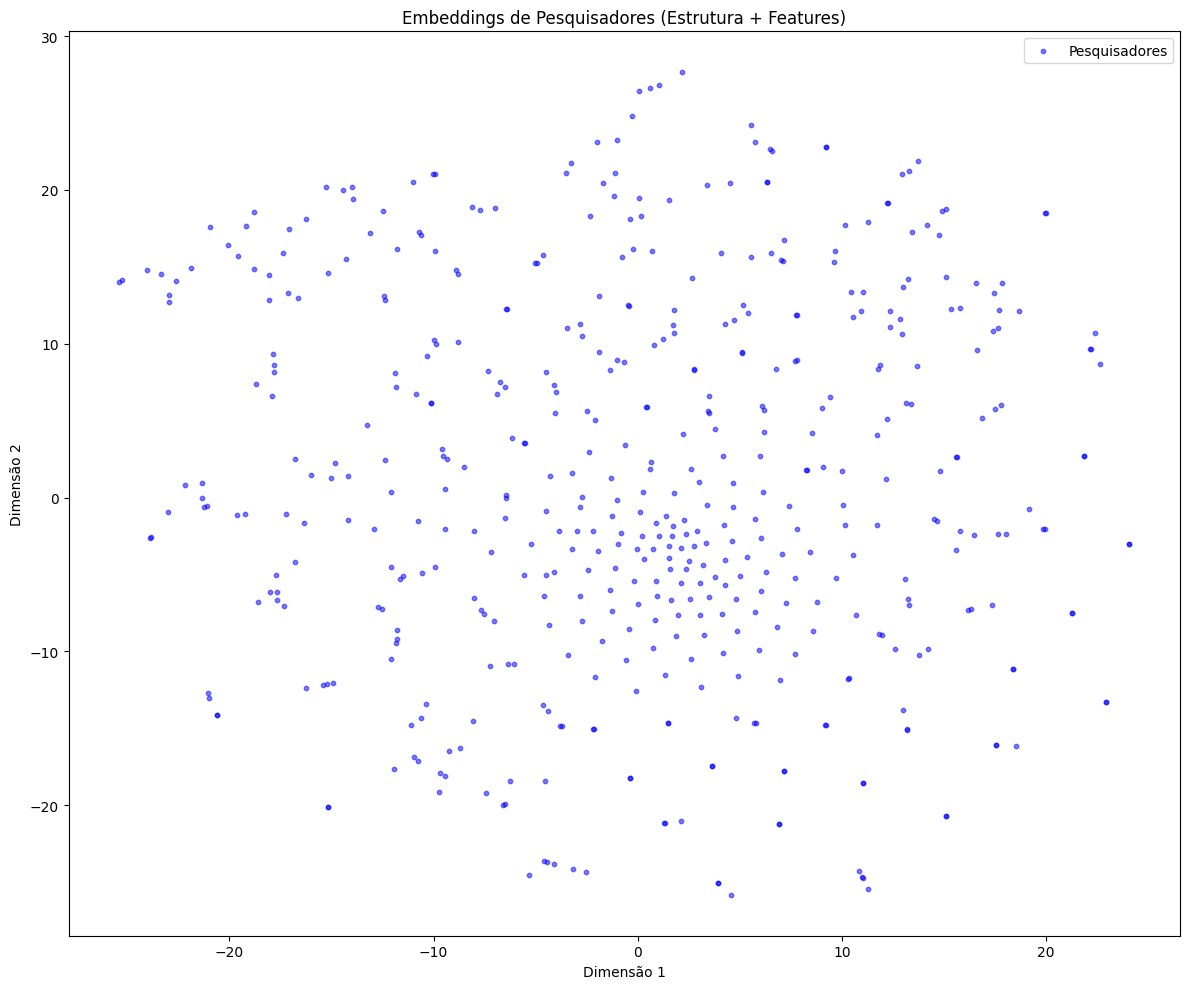

(array([[ 1.10075817e+01, -2.46698856e+01],
        [ 1.66212101e+01,  9.56388569e+00],
        [ 5.53308487e+00,  1.56309481e+01],
        [-8.51156235e+00,  1.99106777e+00],
        [ 1.78377972e+01,  1.39359560e+01],
        [ 2.18600178e+01,  2.67924142e+00],
        [-3.19781089e+00, -3.33395433e+00],
        [ 1.41508598e+01,  1.76964836e+01],
        [-4.03473806e+00,  5.48241615e+00],
        [ 4.81036997e+00, -6.56999636e+00],
        [-2.97539639e+00, -2.15307999e+00],
        [ 9.20110607e+00, -1.47474689e+01],
        [-1.80581608e+01,  1.44602509e+01],
        [ 1.22300186e+01,  5.13376236e+00],
        [-1.16439886e+01, -5.28430414e+00],
        [ 1.36972122e+01,  8.55025005e+00],
        [-9.93108988e-01, -1.78004101e-01],
        [ 1.64917107e+01, -2.40432525e+00],
        [ 1.63199596e+01, -7.25164318e+00],
        [ 1.10166578e+01, -2.46977959e+01],
        [-1.23918591e+01,  2.42403889e+00],
        [ 1.47381983e+01,  1.70731239e+01],
        [ 2.26321735e+01,  8.670

In [ ]:
model, combined_embeddings, feature_names, scaler = treinar_node2vec_com_features(
    digrafo=digrafo,  # Seu dígrafo ponderado
    df_extra_infos=df_extra_infos,  # DataFrame com features
    dimensions=128,
    p=1,
    q=0.5,
    walk_length=80,
    num_walks=10,
    usar_features=True  # Combinar estrutura + features
)

print(f"\nFeatures utilizadas: {feature_names}")

# Encontrar similares
print("\n=== Encontrando Pesquisadores Similares ===")
exemplo_node = list(digrafo.nodes())[0]
print(f"Pesquisador exemplo: {obter_label(digrafo, exemplo_node)}")

similares = encontrar_pesquisadores_similares_combinado(
    combined_embeddings, digrafo, exemplo_node, top_k=10
)

if similares:
    print("\nTop 10 mais similares:")
    for i, res in enumerate(similares, 1):
        print(f"{i}. {res['nome']} (sim: {res['similaridade']:.4f})")

# Clusters
print("\n=== Identificando Clusters ===")
clusters, kmeans_model = analisar_clusters_combinado(
    combined_embeddings, digrafo, n_clusters=5, sample_size=1000
)

for cluster_id, members in clusters.items():
    print(f"\n--- Cluster {cluster_id + 1} ({len(members)} membros) ---")
    for member in members[:5]:
        print(f"  - {member['nome']}")
    if len(members) > 5:
        print(f"  ... e mais {len(members) - 5}")

# Visualização
print("\n=== Visualizando Embeddings ===")
# Se você tiver os top_hubs do HITS, pode destacá-los
top_hubs_ids = [node_id for node_id, score in top_hubs]
visualizar_embeddings_combinado(
    combined_embeddings, digrafo, sample_size=500,
    destacar_top_hubs=top_hubs_ids  # Substitua por top_hubs_ids se quiser
)


In [28]:
# Busca para múltiplos nomes
nomes = ["olindo assis martins filho", "andréa teixeira de carvalho", "joão santana da silva"]
resultados = buscar_similares_por_nome(combined_embeddings, grafo, nomes, top_k=10)

# Acessar resultados individuais
for nome, similares in resultados.items():
    print(f"\nSimilares a {nome}:")
    if similares:
        for s in similares:
            print(f"  - {s['nome']}: {s['similaridade']:.4f}")



Label 'olindo assis martins filho' corresponde ao ID: 6260226537155026
Label 'andréa teixeira de carvalho' corresponde ao ID: 3798623797837575
Label 'joão santana da silva' corresponde ao ID: 1551316349134426

Similares a olindo assis martins filho:
  - silvana maria elói santos: 0.8714
  - luiz eduardo coelho andrade: 0.8669
  - jorge elias kalil filho: 0.8412
  - andréa teixeira de carvalho: 0.8408
  - maria regina d'imperio lima: 0.8276
  - elaine sobral da costa: 0.8166
  - alfredo miranda de goes: 0.8113
  - niels olsen saraiva câmara: 0.8062
  - george alexandre dosreis: 0.8045
  - maria isabel de moraes pinto: 0.7911

Similares a andréa teixeira de carvalho:
  - silvana maria elói santos: 0.9224
  - jorge elias kalil filho: 0.8936
  - constance oliver: 0.8897
  - ana maria caetano de faria: 0.8791
  - alfredo miranda de goes: 0.8654
  - maria celia jamur: 0.8615
  - alvaro luiz bertho dos santos: 0.8553
  - olindo assis martins filho: 0.8408
  - giovanni gazzinelli: 0.8399
  - c

## Salvando Métricas

In [90]:
# def criar_df_metricas_centralizadas(grafo, centralidade_grau, centralidade_intermediacao,
#                                       centralidade_proximidade, pagerank, hubs, authorities):
#     """
#     Cria um DataFrame com todas as métricas e rankings
#     """
#     # Criar lista de todos os nós
#     all_nodes = list(grafo.nodes())

#     # Criar DataFrame base
#     df = pd.DataFrame({
#         'node_id': all_nodes,
#         'nome': [obter_label(grafo, node) for node in all_nodes],
#         'grau_simples': [grafo.degree(node) for node in all_nodes],
#         'centralidade_grau': [centralidade_grau.get(node, 0) for node in all_nodes],
#         'centralidade_intermediacao': [centralidade_intermediacao.get(node, 0) for node in all_nodes],
#         'centralidade_proximidade': [centralidade_proximidade.get(node, 0) for node in all_nodes],
#         'pagerank': [pagerank.get(node, 0) for node in all_nodes],
#         'hub_score': [hubs.get(node, 0) for node in all_nodes],
#         'authority_score': [authorities.get(node, 0) for node in all_nodes]
#     })

#     # Adicionar rankings para cada métrica
#     df['rank_grau_simples'] = df['grau_simples'].rank(ascending=False, method='min').astype(int)
#     df['rank_centralidade_grau'] = df['centralidade_grau'].rank(ascending=False, method='min').astype(int)
#     df['rank_intermediacao'] = df['centralidade_intermediacao'].rank(ascending=False, method='min').astype(int)
#     df['rank_proximidade'] = df['centralidade_proximidade'].rank(ascending=False, method='min').astype(int)
#     df['rank_pagerank'] = df['pagerank'].rank(ascending=False, method='min').astype(int)
#     df['rank_hub'] = df['hub_score'].rank(ascending=False, method='min').astype(int)
#     df['rank_authority'] = df['authority_score'].rank(ascending=False, method='min').astype(int)

#     # Ordenar por PageRank (ou outra métrica de sua escolha)
#     df = df.sort_values('pagerank', ascending=False).reset_index(drop=True)

#     return df

# # Criar DataFrame com todas as métricas
# df_metricas = criar_df_metricas_centralizadas(
#     grafo,
#     centralidade_grau,
#     centralidade_intermediacao,
#     centralidade_proximidade,
#     pagerank,
#     hubs,
#     authorities
# )


In [91]:
def criar_df_weighted_hits(digrafo, nodes_scores):
    """
    Cria DataFrame com os resultados do HITS ponderado
    """
    all_nodes = list(digrafo.nodes())

    df = pd.DataFrame({
        'node_id': all_nodes,
        'nome': [obter_label(digrafo, node) for node in all_nodes],
        'weighted_hub': [nodes_scores[node]['hub'] for node in all_nodes],
        'weighted_authority': [nodes_scores[node]['authority'] for node in all_nodes],
        'node_score': [digrafo.nodes[node].get('score', 0) for node in all_nodes]
    })

    # Adicionar rankings
    df['rank_weighted_hub'] = df['weighted_hub'].rank(ascending=False, method='min').astype(int)
    df['rank_weighted_authority'] = df['weighted_authority'].rank(ascending=False, method='min').astype(int)

    # Ordenar por hub ponderado
    df = df.sort_values('weighted_hub', ascending=False).reset_index(drop=True)

    return df

# Salvar HITS ponderado
df_weighted_hits = criar_df_weighted_hits(digrafo, nodes_scores)

In [92]:
def salvar_similaridades_node2vec(combined_embeddings, grafo, output_file='node2vec_similarities.csv'):
    """
    Calcula e salva as top 10 similaridades para cada pesquisador
    """
    resultados = []

    nodes = list(combined_embeddings.keys())
    print(f"Calculando similaridades para {len(nodes)} pesquisadores...")

    for i, node in enumerate(nodes):
        if (i + 1) % 100 == 0:
            print(f"  Progresso: {i+1}/{len(nodes)}")

        similares = encontrar_pesquisadores_similares_combinado(
            combined_embeddings, grafo, node, top_k=10
        )

        if similares:
            for rank, sim in enumerate(similares, 1):
                resultados.append({
                    'node_id': node,
                    'nome': obter_label(grafo, node),
                    'similar_node_id': sim['id'],
                    'similar_nome': sim['nome'],
                    'similaridade': sim['similaridade'],
                    'rank_similaridade': rank
                })

    df = pd.DataFrame(resultados)
    df.to_csv(output_file, index=False, encoding='utf-8')
    print(f"✓ Arquivo salvo: {output_file}")
    return df


In [93]:
def criar_df_completo(df_metricas, df_weighted_hits, df_extra_infos):
    """
    Combina todas as métricas em um único DataFrame
    """
    # Merge com weighted HITS
    df_completo = df_metricas.merge(
        df_weighted_hits[['node_id', 'weighted_hub', 'weighted_authority',
                          'rank_weighted_hub', 'rank_weighted_authority', 'node_score']],
        on='node_id',
        how='left'
    )

    # Merge com informações extras do Lattes
    df_extra_infos['node_id'] = df_extra_infos['ID-Lattes'].astype(str)

    colunas_interesse = [
        'node_id', 'Artigo-Periódicos', 'Orientações-Doutorado-principal',
        'Orientações-Mestrado-principal', 'Supervisões-Pós-Doutorado',
        'Prêmios-Títulos', 'Membro-corpo-editorial', 'Projetos-Pesquisa',
        'Revisor-periódico', 'Capítulos-livros', 'Livros-completos'
    ]

    df_completo = df_completo.merge(
        df_extra_infos[colunas_interesse],
        on='node_id',
        how='left'
    )

    return df_completo

# Criar e salvar DataFrame completo
df_completo = criar_df_completo(df_metricas, df_weighted_hits, df_extra_infos)
# df_completo.to_csv('metricas_rede_COMPLETO.csv', index=False, encoding='utf-8')

NameError: name 'df_metricas' is not defined

In [95]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import numpy as np
from math import ceil
from tqdm.auto import tqdm

def build_embeddings_matrix(combined_embeddings):
    nodes = list(combined_embeddings.keys())
    emb_matrix = np.vstack([combined_embeddings[n] for n in nodes])
    return nodes, emb_matrix

def normalize_rows(mat):
    norms = np.linalg.norm(mat, axis=1, keepdims=True)
    norms[norms == 0] = 1.0
    return mat / norms

def _process_chunk(start_idx, end_idx, emb_norm, nodes, top_k, grafo):
    # chunk: rows start_idx:end_idx
    chunk = emb_norm[start_idx:end_idx]  # shape (chunk_size, d)
    sims = chunk.dot(emb_norm.T)         # shape (chunk_size, n)
    results_chunk = {}
    for i in range(sims.shape[0]):
        idx_global = start_idx + i
        # argsort top_k+1 (para excluir self), orden decrescente
        row = sims[i]
        # obter índices dos maiores valores rapidamente:
        if top_k + 1 < row.shape[0]:
            top_idx = np.argpartition(-row, top_k + 1)[: top_k + 1]
            top_idx = top_idx[np.argsort(-row[top_idx])]
        else:
            top_idx = np.argsort(-row)
        # filtrar o próprio índice
        top_filtered = [j for j in top_idx if j != idx_global][:top_k]
        target_node = nodes[idx_global]
        resultados = []
        for j in top_filtered:
            node_j = nodes[j]
            resultados.append({
                'id': node_j,
                'nome': obter_label(grafo, node_j),
                'similaridade': float(row[j])
            })
        results_chunk[target_node] = resultados
    return results_chunk

def encontrar_todos_similares_vetorizado(combined_embeddings, grafo, top_k=5,
                                        n_threads=8, chunk_size=1024):
    nodes, emb = build_embeddings_matrix(combined_embeddings)
    emb_norm = normalize_rows(emb)

    n = emb_norm.shape[0]
    n_chunks = ceil(n / chunk_size)
    ranges = [(i * chunk_size, min((i + 1) * chunk_size, n)) for i in range(n_chunks)]

    similares = {}
    # usamos threads para compartilhar memória emb_norm sem copiar
    with ThreadPoolExecutor(max_workers=n_threads) as ex:
        futures = {ex.submit(_process_chunk, r[0], r[1], emb_norm, nodes, top_k, grafo): r for r in ranges}
        for fut in tqdm(as_completed(futures), total=len(futures), desc="Chunks processados"):
            chunk_res = fut.result()
            similares.update(chunk_res)

    return similares


/home/bros/home/joao/tcc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Cálculo de métricas e criação do novo grafo `new_g`
# 1. Métricas de centralidade no grafo original
centralidade_grau = nx.degree_centrality(grafo)
centralidade_intermediacao = nx.betweenness_centrality(grafo, normalized=True)
centralidade_proximidade = nx.closeness_centrality(grafo)
print('Métricas Calculadas')

# 2. HITS ponderado usando a tabela auxiliar (grafo direcionado ponderado)
grafo_enriquecido = adicionar_scores_aos_nos(grafo, df_extra_infos)
digrafo_ponderado = criar_digrafo_ponderado(grafo_enriquecido)
nodes_scores = weighted_hits(digrafo_ponderado, iterations=100)

# Extrair scores de hub e autoridade
hub_scores = {node: scores['hub'] for node, scores in nodes_scores.items()}
authority_scores = {node: scores['authority'] for node, scores in nodes_scores.items()}

# 3. PageRank (no grafo original não-direcionado)
pagerank_scores = nx.pagerank(grafo)
print('Page Rank e Hits Calculados')

# 4. Node2Vec combinado (estrutura + features) com mesma configuração anterior
model, combined_embeddings, feature_names, scaler = treinar_node2vec_com_features(
    digrafo=digrafo,  # Seu dígrafo ponderado
    df_extra_infos=df_extra_infos,  # DataFrame com features
    dimensions=128,
    p=1,
    q=1,
    walk_length=80,
    num_walks=10,
    usar_features=True  # Combinar estrutura + features
)


print('Node2Vec Treinado')

# 5. Encontrar 5 pesquisadores mais similares via Node2Vec para cada nó
print('Iniciando Previsão')
similares_node2vec = {}
# for node in tqdm(grafo.nodes()):
#     similar_ids = encontrar_pesquisadores_similares_combinado(
#         combined_embeddings, grafo, node_id=node, top_k=5
#     )
#     similares_node2vec[node] = similar_ids

similares_node2vec = encontrar_todos_similares_vetorizado(
    combined_embeddings, grafo, top_k=5, n_threads=8, chunk_size=1024
)


# # 6. Criar novo grafo new_g e adicionar atributos calculados aos nós
# print('Construindo novo Grafo')
# new_g = grafo.copy()
# for node in tqdm(new_g.nodes()):
#     new_g.nodes[node]['centralidade_grau'] = centralidade_grau.get(node, 0)
#     new_g.nodes[node]['centralidade_intermediacao'] = centralidade_intermediacao.get(node, 0)
#     new_g.nodes[node]['centralidade_proximidade'] = centralidade_proximidade.get(node, 0)
#     new_g.nodes[node]['hub_score'] = hub_scores.get(node, 0)
#     new_g.nodes[node]['authority_score'] = authority_scores.get(node, 0)
#     new_g.nodes[node]['pagerank'] = pagerank_scores.get(node, 0)
#     new_g.nodes[node]['similares_node2vec'] = similares_node2vec.get(node, [])
    

Métricas Calculadas
Nós atualizados com scores: 10853/10853
Dígrafo criado: 10853 nós, 80590 arcos
Convergiu na iteração 19
Page Rank e Hits Calculados
=== Iniciando treinamento Node2Vec Ponderado (otimizado) ===
Modelo treinado! Vocabulário: 10853 nós
Embeddings combinados: 128 (estrutura) + 10 (features)
Node2Vec Treinado
Iniciando Previsão


Chunks processados: 100%|██████████| 11/11 [00:00<00:00, 12.73it/s]


Construindo novo Grafo


100%|██████████| 10853/10853 [00:00<00:00, 589433.64it/s]


In [101]:
new_g = grafo.copy()

for node in tqdm(new_g.nodes(), desc="Adicionando atributos aos nós"):
    new_g.nodes[node]['centralidade_grau'] = centralidade_grau.get(node, 0)
    new_g.nodes[node]['centralidade_intermediacao'] = centralidade_intermediacao.get(node, 0)
    new_g.nodes[node]['centralidade_proximidade'] = centralidade_proximidade.get(node, 0)
    new_g.nodes[node]['hub_score'] = hub_scores.get(node, 0)
    new_g.nodes[node]['authority_score'] = authority_scores.get(node, 0)
    new_g.nodes[node]['pagerank'] = pagerank_scores.get(node, 0)

    # Serializa a lista de dicionários (id, nome, similaridade) como JSON completo
    similares = similares_node2vec.get(node, [])
    new_g.nodes[node]['similares_node2vec'] = json.dumps(similares, ensure_ascii=False)

# Salva o grafo com os atributos
nx.write_gexf(new_g, "new_graph.gexf")
print("GEXF salvo: new_graph.gexf")


Adicionando atributos aos nós: 100%|██████████| 10853/10853 [00:00<00:00, 103873.23it/s]


GEXF salvo: new_graph.gexf
